In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

In [2]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

In [3]:
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') 
             if '.txt' in b.name]

In [2]:
all_books

NameError: name 'all_books' is not defined

In [ ]:
all_books[1]

<DirEntry '02.Harry Potter and the Chamber of Secrets.txt'>

In [ ]:
# book=all_books[1]
# book_text=open(book,"r")
# print(book_text.readlines())
# book_text.close()

In [ ]:
book= all_books[0]
book_text=open(book, encoding="utf8").read()
book_doc = NER(book_text)

In [ ]:
#visualize identified entities

displacy.render(book_doc[0:2000],style='ent',jupyter=True)

# Load character names

In [ ]:
character_df = pd.read_csv("characters.csv")
import re
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [ ]:
character_df.head(50)

# data cleaning

In [ ]:
#dopping rows where character column has family
character_df=character_df[~character_df.character.str.contains("family")]

#dropping rows which have brackets
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 

#keeping the full name in firstname column if it has mrs or mr
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Mrs.', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Mrs', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df.character.str.contains("'"), character_df['character'], character_df['character_firstname'])

character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Mr.', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Sir', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'The', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Professor', character_df['character'], character_df['character_firstname'])

character_df=character_df[character_df['character_firstname']!='Slytherin']


#removing rows where the character name string starts with lower case (hence not a name)
character_df = character_df[~character_df['character'].str[0].str.islower()]

#keeping rows where character string<3
character_df = character_df[character_df['character'].str.split().str.len().lt(5)]

#dropping duplicate rows
character_df=character_df.drop_duplicates()

character_df=character_df.reset_index(drop=True)

pd.set_option('display.max_rows', None)
character_df.shape[0]
character_df

In [ ]:
character_df=character_df[~(character_df['character_firstname']=='Harold')]

In [ ]:
 #checking number of duplicates 
# character_df["duplicate_value"] = 1
# character_df_values=character_df.groupby(["character","character_firstname"], sort=False, as_index=False).sum()
# character_df_values[character_df_values['duplicate_value']>1]

In [ ]:
# for i in range (1946):
#     if character_df['character_firstname'][i]=='Mrs.':
#         #character_df.character_firstname[i].replace(to_replace='Mrs', value=character_df.character[i])#, regex=True)
#         #character_df.character_firstname[i].replace('Mrs.',character_df.character[i])
       
#         character_df['character_firstname'][i] = character_df['character_firstname'][i].replace(character_df['character'][i])

# get the entity list per sentence

In [ ]:
sent_entity=[]

for sent in book_doc.sents:
    entity_list=[ent.text for ent in sent.ents]
    sent_entity.append({"sentence":sent,"entities":entity_list})
    
sent_entity_df=pd.DataFrame(sent_entity)


In [ ]:
sent_entity_df

In [ ]:
#function to filter non_character or empty entities

def filter_entity(ent_list,character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.character) #if entites match with the character name 
            or ent in list(character_df.character_firstname)] #or if character first name matches

In [ ]:
#test
filter_entity(['Harry','two','Ginny'],character_df)

['Harry', 'Ginny']

In [ ]:
#finding entities that are in the character list

sent_entity_df['character_entities']=sent_entity_df['entities'].apply(lambda x: filter_entity(x,character_df))


In [ ]:
#removing empty entities
sent_entity_df_filtered=sent_entity_df[sent_entity_df['character_entities'].map(len)>0]

sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)
sent_entity_df_filtered


In [ ]:
# creating an empty column of lists

sent_entity_df_filtered['entity_full']=''

for i in range(sent_entity_df_filtered.shape[0]):
    sent_entity_df_filtered['entity_full'][i]=list(sent_entity_df_filtered['entity_full'][i])
    
sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)

type(sent_entity_df_filtered['entity_full'][0])

list

In [ ]:
#adding the first name for all characters to the column

for i in range(sent_entity_df_filtered.shape[0]):
    for j in range(len(sent_entity_df_filtered['character_entities'][i])):
        sent_entity_df_filtered['entity_full'][i].append(character_df.loc[( character_df['character'] == sent_entity_df_filtered['character_entities'][i][j])|(character_df['character_firstname'] == sent_entity_df_filtered['character_entities'][i][j]), 'character'].to_list())     

In [ ]:
#converting list of list to list in entity full

for i in range(sent_entity_df_filtered.shape[0]):
    sent_entity_df_filtered['entity_full'][i]=[ item for elem in sent_entity_df_filtered['entity_full'][i] for item in elem]


In [ ]:
sent_entity_df_filtered

# creating relationships

In [ ]:
window_size=5
relationships=[]

for i in range(sent_entity_df_filtered.index[-1]): #-1 for i in last index of the df
    
    #end index of the window
    #end_i=i+5 but if we r at the end then i+5 exceeds the df  therefore:
    end_i=min(i+5,sent_entity_df_filtered.index[-1])
    
    #storing all the entites occuring in the window of 5 sentences into a list
    char_list=sum((sent_entity_df_filtered.loc[i: end_i].entity_full), [])
    #calling a sum function and merging this list with an empty list
    
     #removing duplicated characters in the same window 
    char_unique=[char_list[i] for i in range(len(char_list))
                  if (i==0) or char_list[i]!=char_list[i-1]]
    
    if len(char_unique)>1: #since if only one character in window then np relationship possible
        for idx, a in enumerate(char_unique[:-1]): #-1 so that we only iterate till the second last element
            b= char_unique[idx+1]
            relationships.append({'source':a,"target":b})

In [ ]:
relationship_df = pd.DataFrame(relationships)
relationship_df

In [ ]:
#sort cases with a->b with b->a
relationship_df=pd.DataFrame(np.sort(relationship_df.values,axis=1),columns=relationship_df.columns)
relationship_df

In [ ]:
relationship_df["value"]= 1 
#each row has weight one ..so we can add this to find the wt of each relation

In [ ]:
relationship_df.groupby(['source','target'])#to put the same source traget(same rel) together
relationship_df.head(10)

,source,target,value
0,Dudley Dursley,Harry Potter,1
1,Dudley Dursley,Harry Potter,1
2,Dudley Dursley,Harry Potter,1
3,Dudley Dursley,Harry Potter,1
4,Dudley Dursley,Harry Potter,1
5,Dudley Dursley,Harry Potter,1
6,Dudley Dursley,Harry Potter,1
7,Dudley Dursley,Harry Potter,1
8,Dudley Dursley,Harry Potter,1
9,Dudley Dursley,Harry Potter,1


In [ ]:
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df

# Graph Analysis

In [ ]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

# Graph visualization


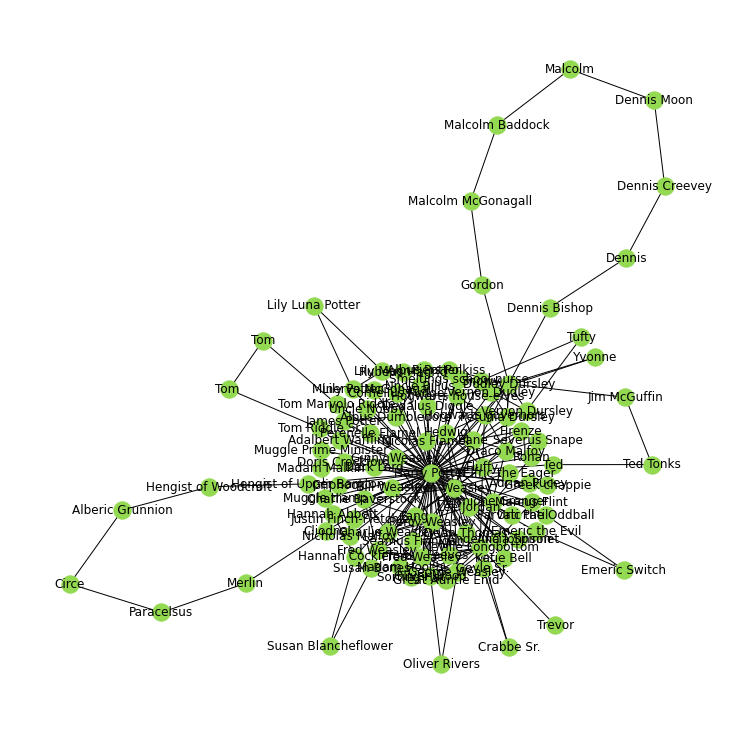

In [ ]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='#93d952', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
# from pyvis.network import Network

# net = Network(height='750px', width='1000px', bgcolor='#222222', font_color='white')

# # set the physics layout of the network
# net.barnes_hut()
# #hp_data = relationship_df

# sources = relationship_df['source']
# targets = relationship_df['target']
# weights = relationship_df['value']

# edge_data = zip(sources, targets, weights)

# for e in edge_data:
#     src = e[0]
#     dst = e[1]
#     w = e[2]

#     net.add_node(src, src, title=src,color='#93d952',alpha=0.3)
#     net.add_node(dst, dst, title=dst,color='#93d952')
#     net.add_edge(src, dst, value=w,color='#93d952')
    
# net.save_graph('weird.html')
    

In [ ]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
#nx.set_edge_attributes(G,color='#93d952',alpha=0.3)

net.from_nx(G)
net.show("philosopherStone.html")

# community detection

In [ ]:
communities = community_louvain.best_partition(G)

In [ ]:
nx.set_node_attributes(G, communities, 'group')

In [ ]:
com_net = Network(notebook = True, width="1000px", height="1000px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("philosopherStone_communities.html")

# Characters throughout books 

In [ ]:
from lib.utils.functions2 import *

In [ ]:
book_graphs=[]
all_books = [b for b in os.scandir('data')if '.txt' in b.name]

nlp=spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [ ]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
    
    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    ##
    # creating an empty column of lists
    sent_entity_df_filtered['entity_full']=''

    for i in range(sent_entity_df_filtered.shape[0]):
        sent_entity_df_filtered['entity_full'][i]=list(sent_entity_df_filtered['entity_full'][i])
        
    sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)
   
    #adding the first name for all characters to the column

    for i in range(sent_entity_df_filtered.shape[0]):
        for j in range(len(sent_entity_df_filtered['character_entities'][i])):
            sent_entity_df_filtered['entity_full'][i].append(character_df.loc[( character_df['character'] == sent_entity_df_filtered['character_entities'][i][j])|(character_df['character_firstname'] == sent_entity_df_filtered['character_entities'][i][j]), 'character'].to_list())     
            
    #converting list of list to list in entity full

    for i in range(sent_entity_df_filtered.shape[0]):
        sent_entity_df_filtered['entity_full'][i]=[ item for elem in sent_entity_df_filtered['entity_full'][i] for item in elem]
    ##
                
    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    book_graphs.append(G)

C:\Users\chand\AppData\Local\Temp\ipykernel_54844\3143536251.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['entity_full']=''


KeyError: 0